## Install & Import Libraries and Functions

In [24]:
! pip install prophet
! pip install yfinance==0.1.44
! pip install pystan==2.19.1.1 prophet plotly

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline
import plotly
import math as math

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer

#mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from prophet import Prophet

import scipy
import yfinance as yf
import time
import datetime

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.options.display.float_format = '{:,.2f}'.format

## Read Data (Y-finance & LS)


In [3]:
# Update Today Date
Today=datetime.datetime.now()

In [4]:
#Download from Yahoo finance
ticker="CT=F"
period1=int(time.mktime(datetime.datetime(2000,3,1,23,59).timetuple()))
period2=int(time.mktime(Today.timetuple())) # To update with latest date
interval='1d' #1wk,1m

query_string=f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'

dfy=pd.read_csv(query_string,parse_dates=['Date'],index_col="Date")

In [5]:
print(query_string)

https://query1.finance.yahoo.com/v7/finance/download/CT=F?period1=951955140&period2=1640001010&interval=1d&events=history&includeAdjustedClose=true


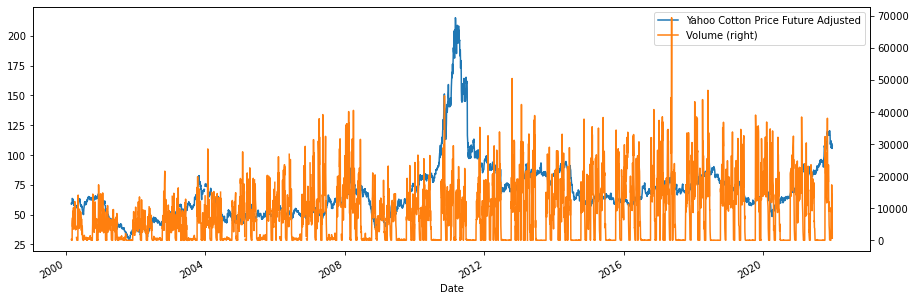

In [5]:
# Yahoo Finance CP data vs. LSE data
plt.clf()
dfy['Adj Close'].plot(label='Yahoo Cotton Price Future Adjusted', legend=True,figsize=(15,5))
# dfy['Close'].plot(label='Yahoo Cotton Price Future', legend=True)
dfy['Volume'].plot(label='Volume', secondary_y=True, legend=True)

plt.show()  # show the plot

In [7]:
dfy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5557 entries, 2000-03-01 to 2021-12-20
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5467 non-null   float64
 1   High       5467 non-null   float64
 2   Low        5467 non-null   float64
 3   Close      5467 non-null   float64
 4   Adj Close  5467 non-null   float64
 5   Volume     5467 non-null   float64
dtypes: float64(6)
memory usage: 303.9 KB


In [8]:
dfy.tail(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-07,111.93,112.15,111.39,111.27,111.27,9.00
2021-12-08,111.55,111.55,111.55,111.55,111.55,"9,451.00"
2021-12-09,106.29,107.00,105.01,106.59,106.59,"10,134.00"
2021-12-10,106.29,107.11,105.72,106.23,106.23,"9,021.00"
2021-12-13,106.23,107.82,106.01,106.81,106.81,"9,152.00"
2021-12-14,106.72,107.04,105.64,105.90,105.90,"8,779.00"
2021-12-15,105.90,106.63,105.45,105.79,105.79,"9,658.00"
2021-12-16,105.88,109.79,105.88,109.68,109.68,"17,271.00"
2021-12-17,109.22,109.40,106.94,107.30,107.30,"17,271.00"


In [6]:
#drop null values
dfy=dfy.dropna()

In [10]:
dfy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5466 entries, 2000-03-01 to 2021-12-17
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5466 non-null   float64
 1   High       5466 non-null   float64
 2   Low        5466 non-null   float64
 3   Close      5466 non-null   float64
 4   Adj Close  5466 non-null   float64
 5   Volume     5466 non-null   float64
dtypes: float64(6)
memory usage: 298.9 KB


In [7]:
dfy.describe()

,Open,High,Low,Close,Adj Close,Volume
count,"5,469.00","5,469.00","5,469.00","5,469.00","5,469.00","5,469.00"
mean,69.31,70.04,68.56,69.25,69.25,"7,684.58"
std,23.99,24.42,23.53,23.95,23.95,"8,746.73"
min,28.35,28.95,28.20,28.52,28.52,0.00
25%,54.55,55.00,54.08,54.55,54.55,59.00
50%,64.98,65.51,64.49,64.91,64.91,"5,218.00"
75%,78.38,79.22,77.75,78.35,78.35,"13,106.00"
max,215.62,227.00,210.75,215.15,215.15,"69,381.00"


In [8]:
df_p=dfy[['Adj Close']]
df_p.tail()

,Adj Close
Date,
2021-12-16,109.68
2021-12-17,107.30
2021-12-20,105.54
2021-12-21,107.27
2021-12-22,107.46


In [9]:
# Train Test Split train data till 2020, test data as of 2021
train_df = df_p.loc['2000':'2020-06', :]
test_df = df_p.loc['2020-07':, :]
renaming_dict = {"Date" : "ds", "Adj Close" : "y"}
df_prophet = train_df.copy().reset_index().rename(renaming_dict, axis=1)

test_df1 = test_df.copy().reset_index().rename(renaming_dict, axis=1)

In [11]:
print(test_df1.shape)
test_df1.tail()

(375, 2)


,ds,y
370,2021-12-16,109.68
371,2021-12-17,107.30
372,2021-12-20,105.54
373,2021-12-21,107.27
374,2021-12-22,107.46


## Neural Prophet

In [10]:
!pip install neuralprophet[live]
from neuralprophet import NeuralProphet

  Using cached neuralprophet-0.3.0-py3-none-any.whl (67 kB)
  Using cached torch_lr_finder-0.2.1-py3-none-any.whl (11 kB)
  Using cached dataclasses-0.6-py3-none-any.whl (14 kB)
  Using cached holidays-0.11.3.1-py3-none-any.whl (155 kB)
  Using cached livelossplot-0.5.4-py3-none-any.whl (22 kB)
  Attempting uninstall: holidays
    Found existing installation: holidays 0.10.5.2
    Uninstalling holidays-0.10.5.2:
      Successfully uninstalled holidays-0.10.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


INFO - (NP.forecaster._handle_missing_data) - 2333 missing dates added.
INFO - (NP.forecaster._handle_missing_data) - 2333 NaN values in column y were auto-imputed.
  0%|          | 0/256 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /opt/conda/lib/python3.8/site-packages/torch/nn/modules/container.py:552: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")

Epoch[256/256]: 100%|██████████| 256/256 [01:58<00:00,  2.16it/s, SmoothL1Loss=0.000713, MAE=4.42, RMSE=6.92, RegLoss=0]
INFO - (NP.forecaster._handle_missing_data) - 2333 missing dates added.
INFO - (NP.forecaster._handle_missing_data) - 2333 NaN values in column y were auto-imputed.
WARNING - (NP.plotting.plot) - Legend is available only for the ten first handles


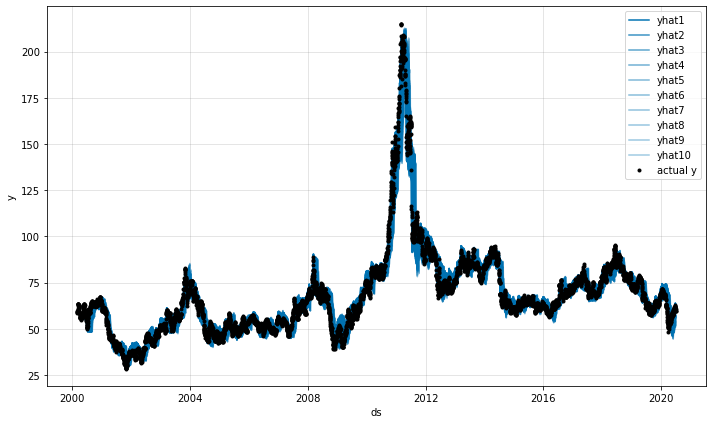

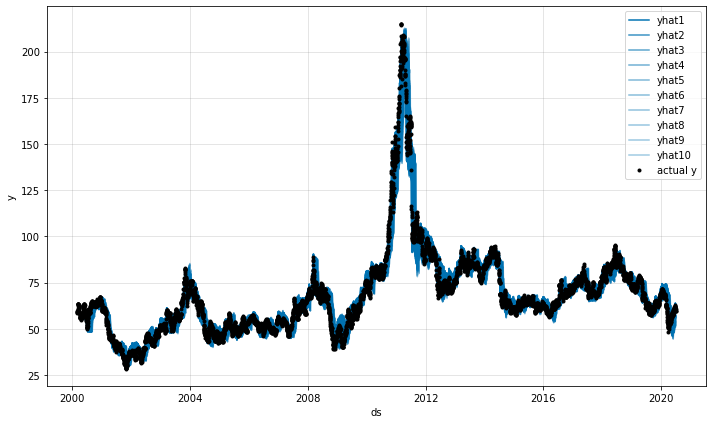

In [14]:
#BASE model to forecast for 60 days 

m = NeuralProphet(daily_seasonality=False, n_lags=100, n_forecasts=60,
                  n_changepoints=5, learning_rate=0.1,epochs=256, 
#                   optimizer="SDG"
#                   num_hidden_layers=2,
                  batch_size=50, normalize='minmax')

metrics = m.fit(df_prophet, freq='D')
predicted = m.predict(df_prophet)
m.plot(predicted)

INFO - (NP.forecaster._handle_missing_data) - 165 missing dates added.
INFO - (NP.forecaster._handle_missing_data) - 165 NaN values in column y were auto-imputed.
WARNING - (py.warnings._showwarnmsg) - /opt/conda/lib/python3.8/site-packages/torch/nn/modules/container.py:552: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")

WARNING - (NP.plotting.plot) - Legend is available only for the ten first handles


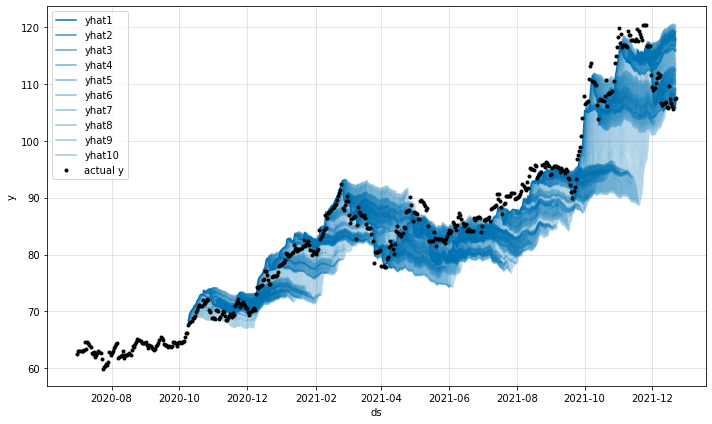

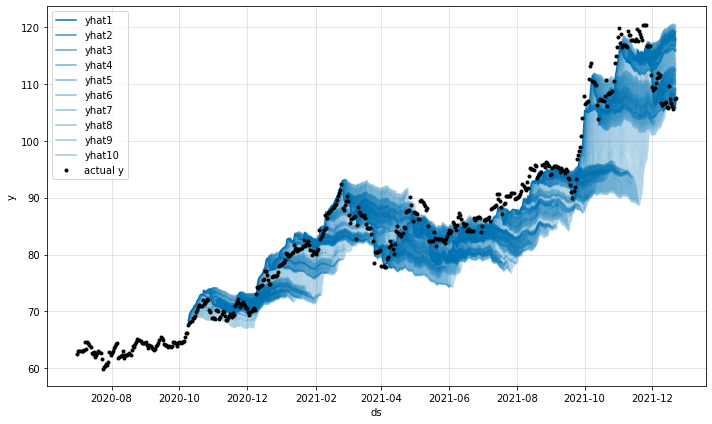

In [15]:
#Need min n_lag row of test data
predicted_test = m.predict(test_df1)
m.plot(predicted_test)

INFO - (NP.forecaster._handle_missing_data) - 2333 missing dates added.
INFO - (NP.forecaster._handle_missing_data) - 2333 NaN values in column y were auto-imputed.
  0%|          | 0/256 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /opt/conda/lib/python3.8/site-packages/torch/nn/modules/container.py:552: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")

Epoch[256/256]: 100%|██████████| 256/256 [01:58<00:00,  2.17it/s, SmoothL1Loss=0.000713, MAE=4.42, RMSE=6.9, RegLoss=0] 
INFO - (NP.forecaster._handle_missing_data) - 2333 missing dates added.
INFO - (NP.forecaster._handle_missing_data) - 2333 NaN values in column y were auto-imputed.
WARNING - (NP.plotting.plot) - Legend is available only for the ten first handles


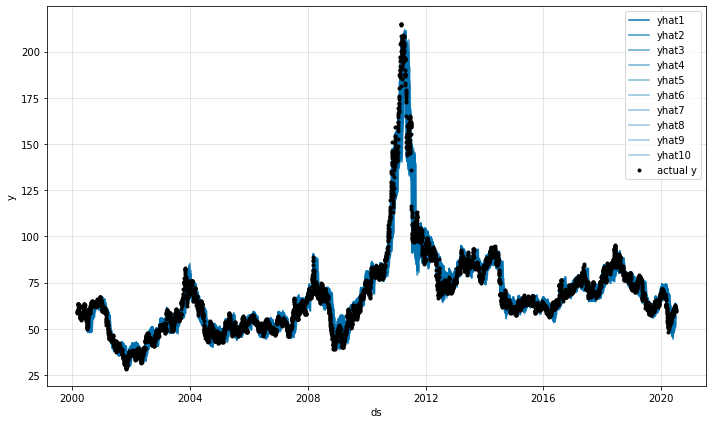

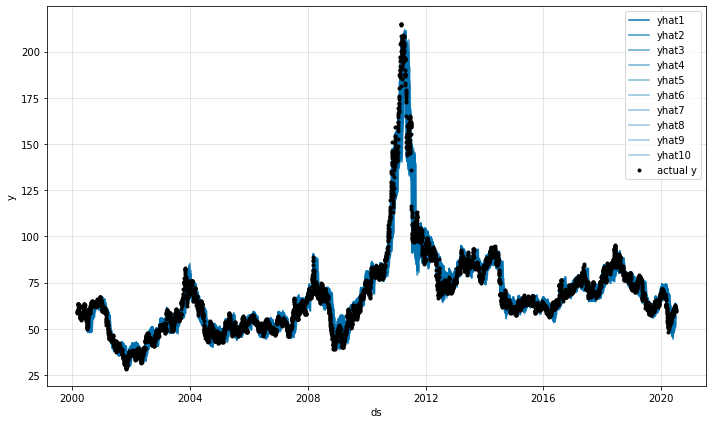

In [13]:
#BASE model to forecast for 60 days, Nr of change points = 5 default

m = NeuralProphet(daily_seasonality=False, n_lags=100, n_forecasts=60,
                  n_changepoints=5, learning_rate=0.1,epochs=256, 
#                   optimizer="SDG"
#                   num_hidden_layers=2,
                  batch_size=50, normalize='minmax')

metrics = m.fit(df_prophet, freq='D')
predicted = m.predict(df_prophet)
m.plot(predicted)

INFO - (NP.forecaster._handle_missing_data) - 165 missing dates added.
INFO - (NP.forecaster._handle_missing_data) - 165 NaN values in column y were auto-imputed.
WARNING - (py.warnings._showwarnmsg) - /opt/conda/lib/python3.8/site-packages/torch/nn/modules/container.py:552: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")

WARNING - (NP.plotting.plot) - Legend is available only for the ten first handles


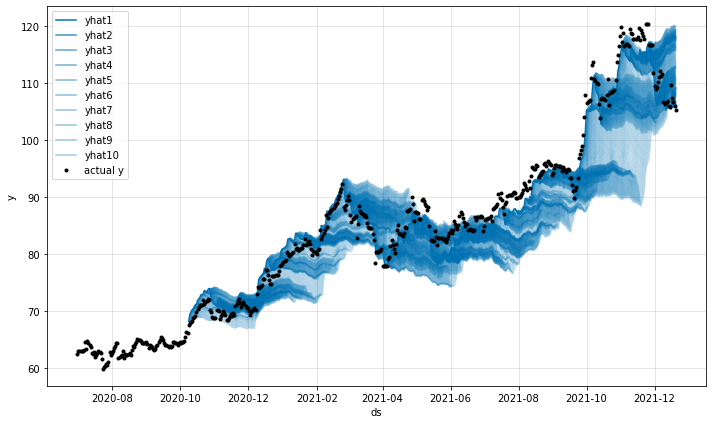

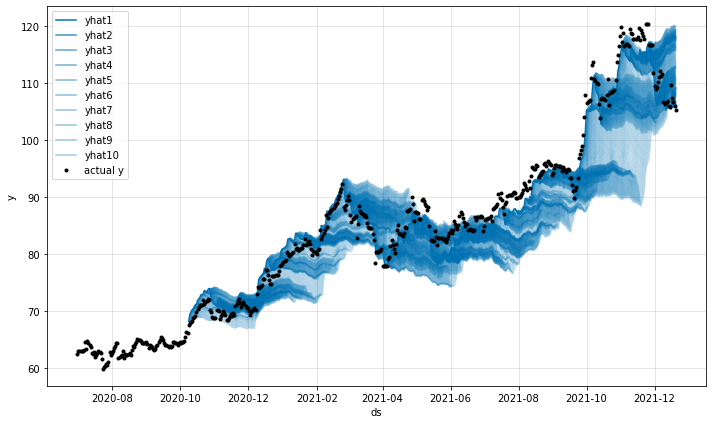

In [14]:
#Need min n_lag row of test data
predicted_test = m.predict(test_df1)
m.plot(predicted_test)

In [16]:
predicted_test.tail()

,ds,y,yhat1,residual1,yhat2,residual2,yhat3,residual3,yhat4,residual4,yhat5,residual5,yhat6,residual6,yhat7,residual7,yhat8,residual8,yhat9,residual9,yhat10,residual10,yhat11,residual11,yhat12,residual12,yhat13,residual13,yhat14,residual14,yhat15,residual15,yhat16,residual16,yhat17,residual17,yhat18,residual18,yhat19,residual19,yhat20,residual20,yhat21,residual21,yhat22,residual22,yhat23,residual23,yhat24,residual24,yhat25,residual25,yhat26,residual26,yhat27,residual27,yhat28,residual28,yhat29,residual29,yhat30,residual30,yhat31,residual31,yhat32,residual32,yhat33,residual33,yhat34,residual34,yhat35,residual35,yhat36,residual36,yhat37,residual37,yhat38,residual38,yhat39,residual39,yhat40,residual40,yhat41,residual41,yhat42,residual42,yhat43,residual43,yhat44,residual44,yhat45,residual45,yhat46,residual46,yhat47,residual47,yhat48,residual48,yhat49,residual49,yhat50,residual50,yhat51,residual51,yhat52,residual52,yhat53,residual53,yhat54,residual54,yhat55,residual55,yhat56,residual56,yhat57,residual57,yhat58,residual58,yhat59,residual59,yhat60,residual60,ar1,ar2,ar3,ar4,ar5,ar6,ar7,ar8,ar9,ar10,ar11,ar12,ar13,ar14,ar15,ar16,ar17,ar18,ar19,ar20,ar21,ar22,ar23,ar24,ar25,ar26,ar27,ar28,ar29,ar30,ar31,ar32,ar33,ar34,ar35,ar36,ar37,ar38,ar39,ar40,ar41,ar42,ar43,ar44,ar45,ar46,ar47,ar48,ar49,ar50,ar51,ar52,ar53,ar54,ar55,ar56,ar57,ar58,ar59,ar60,trend,season_yearly,season_weekly
535,2021-12-18,106.71,107.39,0.67,108.72,2.01,105.75,-0.97,106.26,-0.45,106.77,0.06,106.55,-0.16,106.49,-0.23,106.45,-0.26,108.03,1.32,112.46,5.74,112.6,5.89,112.8,6.08,111.65,4.94,110.97,4.26,110.23,3.51,109.92,3.2,110.9,4.19,113.33,6.62,117.14,10.43,116.65,9.93,116.55,9.83,117.46,10.75,120.34,13.63,120.37,13.66,119.89,13.17,118.26,11.55,118.77,12.06,119.25,12.53,119.35,12.64,118.29,11.58,119.38,12.67,118.09,11.38,117.82,11.11,117.68,10.97,117.6,10.88,117.71,10.99,118.32,11.61,118.35,11.63,118.44,11.72,115.98,9.26,116.0,9.29,116.2,9.48,115.82,9.11,116.22,9.5,118.33,11.61,117.84,11.12,119.7,12.99,118.21,11.5,116.51,9.8,115.0,8.28,114.1,7.38,110.83,4.11,109.62,2.91,109.25,2.53,109.31,2.59,109.39,2.68,109.0,2.29,107.84,1.12,111.19,4.48,108.65,1.94,71.92,73.26,70.28,70.8,71.31,71.09,71.02,70.99,72.57,76.99,77.14,77.33,76.19,75.51,74.76,74.46,75.44,77.87,81.68,81.18,81.08,82.0,84.88,84.91,84.42,82.8,83.31,83.78,83.89,82.83,83.92,82.63,82.36,82.22,82.13,82.24,82.86,82.88,82.97,80.51,80.54,80.74,80.36,80.75,82.86,82.37,84.24,82.75,81.05,79.53,78.63,75.36,74.16,73.78,73.84,73.93,73.54,72.37,75.73,73.19,34.09,1.38,-0.0
536,2021-12-19,106.13,106.88,0.75,107.74,1.61,108.97,2.84,105.71,-0.41,106.44,0.32,106.83,0.7,106.59,0.46,106.55,0.42,106.65,0.52,108.14,2.01,112.54,6.41,112.86,6.73,113.03,6.9,111.77,5.64,110.98,4.86,110.38,4.25,109.97,3.84,110.96,4.84,113.38,7.26,117.12,10.99,116.88,10.75,116.79,10.67,117.68,11.55,120.49,14.37,120.4,14.27,119.76,13.63,118.17,12.04,118.63,12.5,119.3,13.17,119.42,13.29,118.44,12.31,119.47,13.35,118.18,12.05,118.02,11.89,117.77,11.65,117.49,11.37,117.62,11.5,118.35,12.23,118.31,12.18,118.41,12.29,116.33,10.2,116.18,10.05,116.25,10.12,115.98,9.85,116.33,10.21,118.29,12.16,117.97,11.84,119.74,13.61,118.32,12.19,116.57,10.45,115.06,8.94,114.09,7.97,110.91,4.78,109.6,3.48,109.23,3.11,109.41,3.28,109.52,3.39,108.97,2.84,107.88,1.75,111.08,4.96,71.33,72.19,73.41,70.16,70.89,71.27,71.04,70.99,71.1,72.59,76.99,77.31,77.47,76.22,75.43,74.83,74.41,75.41,77.83,81.57,81.33,81.24,82.13,84.94,84.84,84.21,82.62,83.07,83.74,83.86,82.88,83.92,82.63,82.47,82.22,81.94,82.07,82.8,82.76,82.86,80.77,80.62,80.7,80.43,80.78,82.73,82.42,84.18,82.76,81.02,79.51,78.54,75.36,74.05,73.68,73.86,73.96,73.42,72.33,75.53,34.09,1.47,-0.01
537,2021-12-20,105.54,105.76,0.22,106.68,1.14,107.72,2.18,109.01,3.47,105.83,0.29,106.25,0.71,106.44,0.9,106.48,0.94,106.37,0.83,106.33,0.79,108.01,2.47,112.45,6.91,112.66,7.12,112.88,7.34,111.92,6.38,110.93,5.39,110.31,4.77,109.95,4.41,111.05,5.51,113.32,7.78,116.98,11.44,116.53,10.99,116.49,10.95,117.35,11.81,120.34,14.8,120.6,15.06,11

In [34]:
test_yhat1=predicted_test.yhat1.iloc[101:]
test_y=predicted_test.y.iloc[101:]

In [37]:
msr=mean_squared_error(test_y, test_yhat1)
rmse=math.sqrt(msr)
rmse

2.343026731701923

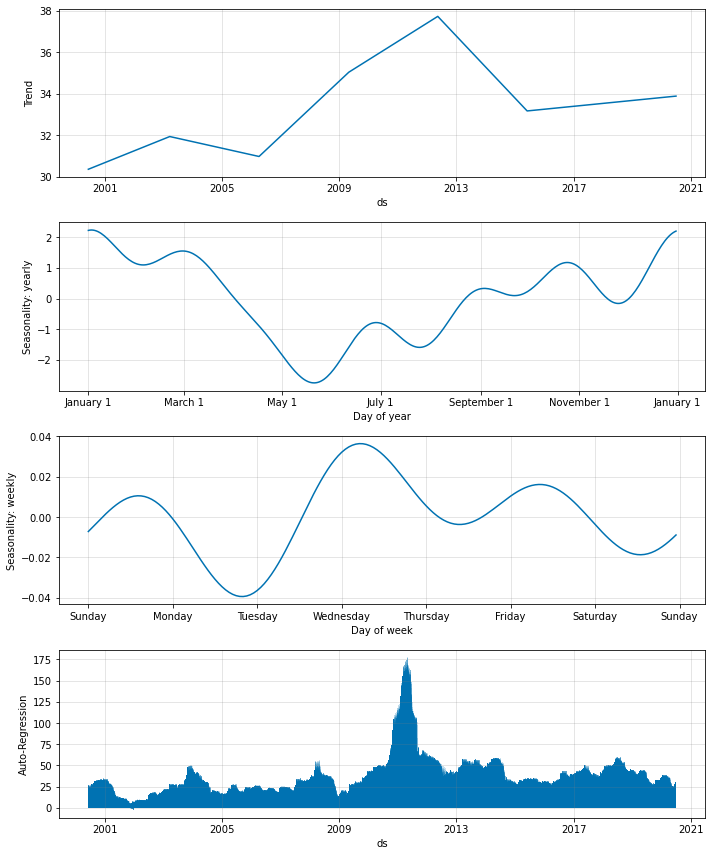

In [38]:
fig_comp = m.plot_components(predicted)

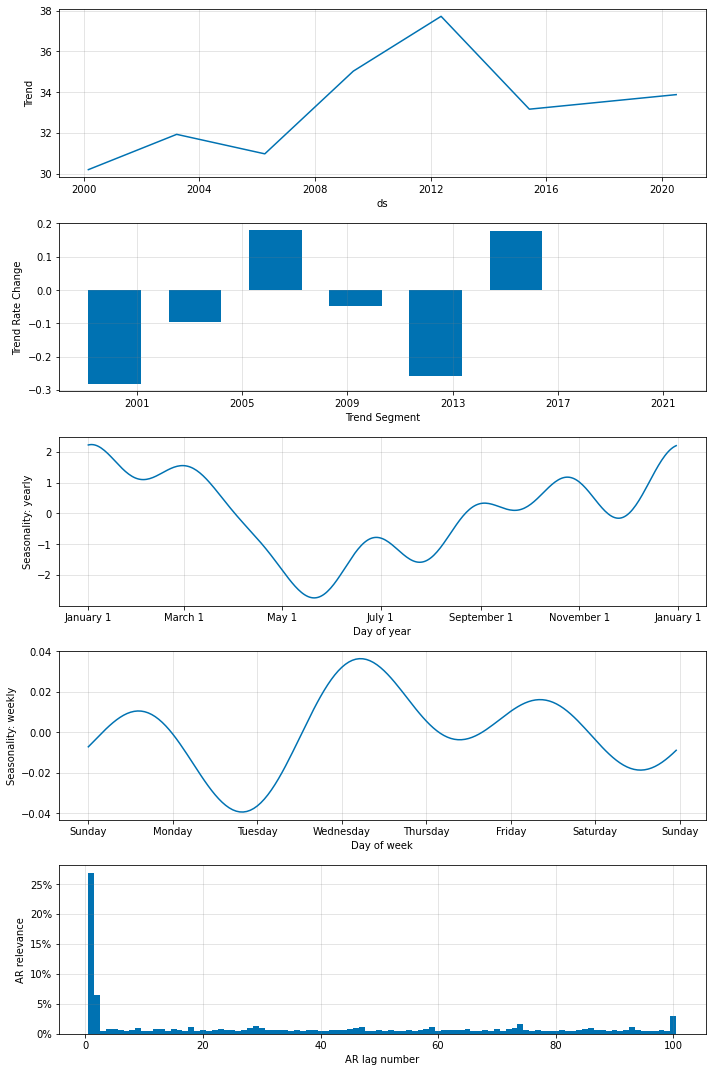

In [39]:
fig_param = m.plot_parameters()

INFO - (NP.forecaster._handle_missing_data) - 165 missing dates added.
INFO - (NP.forecaster._handle_missing_data) - 165 NaN values in column y were auto-imputed.
WARNING - (NP.plotting.plot) - Legend is available only for the ten first handles


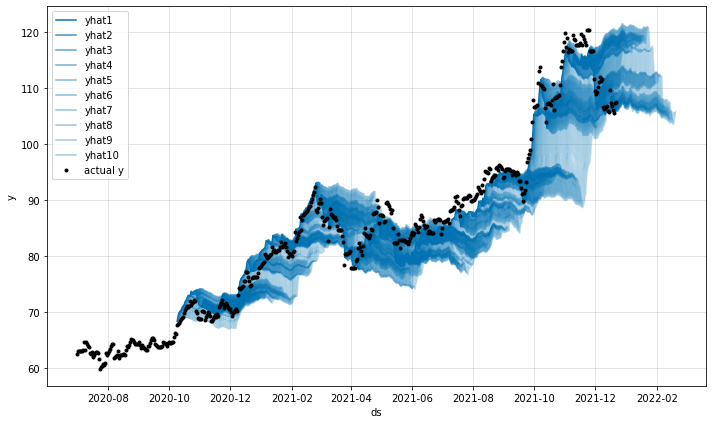

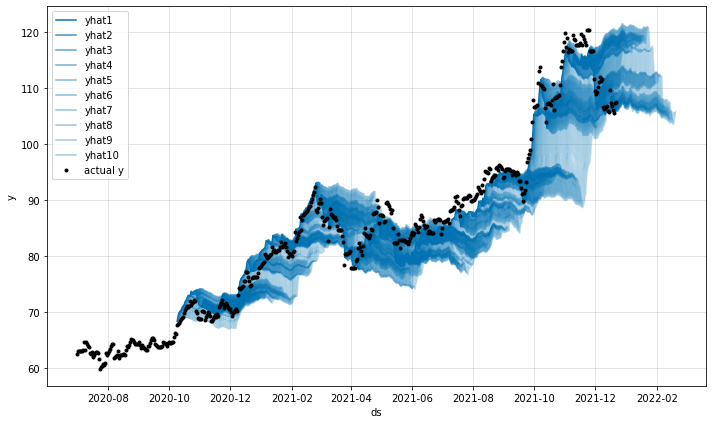

In [40]:
# Forecast for the future
future = m.make_future_dataframe(test_df1, periods=60, n_historic_predictions=True)
# forecast = m.predict(future,decompose=False, raw=True)
# forecast.tail(10)
forecast=m.predict(future)
m.plot(forecast)

In [45]:
forecast=m.predict(future)


INFO - (NP.forecaster._handle_missing_data) - 165 missing dates added.
INFO - (NP.forecaster._handle_missing_data) - 165 NaN values in column y were auto-imputed.


,ds,y,yhat1,residual1,yhat2,residual2,yhat3,residual3,yhat4,residual4,yhat5,residual5,yhat6,residual6,yhat7,residual7,yhat8,residual8,yhat9,residual9,yhat10,residual10,yhat11,residual11,yhat12,residual12,yhat13,residual13,yhat14,residual14,yhat15,residual15,yhat16,residual16,yhat17,residual17,yhat18,residual18,yhat19,residual19,yhat20,residual20,yhat21,residual21,yhat22,residual22,yhat23,residual23,yhat24,residual24,yhat25,residual25,yhat26,residual26,yhat27,residual27,yhat28,residual28,yhat29,residual29,yhat30,residual30,yhat31,residual31,yhat32,residual32,yhat33,residual33,yhat34,residual34,yhat35,residual35,yhat36,residual36,yhat37,residual37,yhat38,residual38,yhat39,residual39,yhat40,residual40,yhat41,residual41,yhat42,residual42,yhat43,residual43,yhat44,residual44,yhat45,residual45,yhat46,residual46,yhat47,residual47,yhat48,residual48,yhat49,residual49,yhat50,residual50,yhat51,residual51,yhat52,residual52,yhat53,residual53,yhat54,residual54,yhat55,residual55,yhat56,residual56,yhat57,residual57,yhat58,residual58,yhat59,residual59,yhat60,residual60,ar1,ar2,ar3,ar4,ar5,ar6,ar7,ar8,ar9,ar10,ar11,ar12,ar13,ar14,ar15,ar16,ar17,ar18,ar19,ar20,ar21,ar22,ar23,ar24,ar25,ar26,ar27,ar28,ar29,ar30,ar31,ar32,ar33,ar34,ar35,ar36,ar37,ar38,ar39,ar40,ar41,ar42,ar43,ar44,ar45,ar46,ar47,ar48,ar49,ar50,ar51,ar52,ar53,ar54,ar55,ar56,ar57,ar58,ar59,ar60,trend,season_yearly,season_weekly
0,2020-07-01,62.58,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,2020-07-02,63.05,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,2020-07-03,63.05,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,

In [53]:
df_forecast=forecast.filter(regex="yhat") # only yhat variables
df_yhat=df_forecast.fillna(method="ffill") #foreward fill NaN values
df_pred=df_yhat.iloc[-1].filter(regex="yhat").tolist() #prediction values last row
IDX=df_forecast.yhat1.last_valid_index() #last valide Index
df_dates=forecast.ds.iloc[IDX:].tolist() #valid index to catch dates from forecast DF
final_df=pd.DataFrame({"Date":df_dates,"Predictions":df_pred}).set_index("Date") #create dataframe

In [54]:
final_df.tail()

,Predictions
Date,
2022-02-16,105.87
2022-02-17,105.67
2022-02-18,105.54
2022-02-19,105.53
2022-02-20,105.82


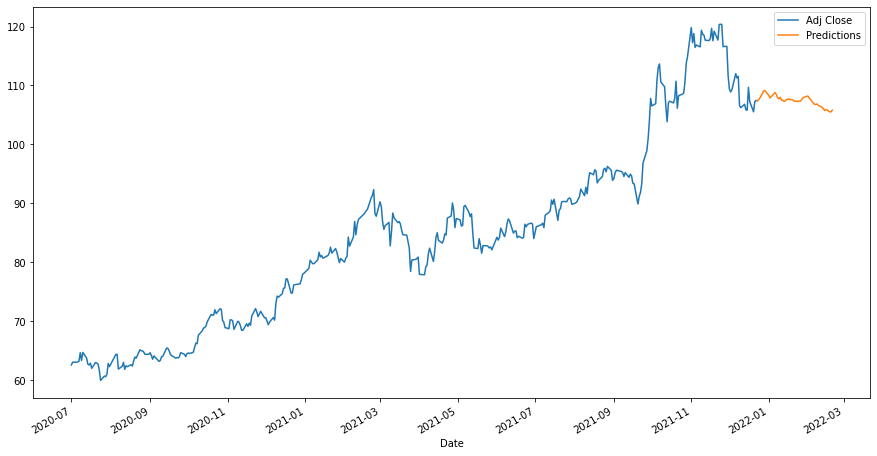

In [55]:
df_plot=pd.concat([test_df,final_df],axis=1)
# df_plot.columns()
# # df_plot.columns((["Prediction", "Actual_to_date","Prediction_1"])
# # df_plot.to_csv('plot_data.csv',index=False)
df_plot.plot(figsize=(15,8),legend=True);

In [57]:
avg_test=test_df1.y.mean()

In [59]:
1-rmse/avg_test

0.9722148251772672

In [60]:
avg_train=df_prophet.y.mean()

In [61]:
1-6.7/avg_train

0.901677379873381